In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Limpieza

In [2]:
eph2004 = pd.read_stata('./input/Individual_t104.dta', convert_categoricals= False)
#eph2024 = pd.read_excel('./input/usu_individual_T124.xlsx') # Ya lo guardé como csv, no tengo que cargarlo más como excel
# eph2024.to_csv('./input/usu_individual_T124.csv, index = False)

In [3]:
tipos = eph2004.dtypes.to_dict() # Agarro los dtypes de la base de 2004
# Lo guardo como diccionario para cuando cargue el csv poder especificarle al read_csv los dtypes de la base de 2024
# Cambio los dtypes de las columnas que me van a a interesar
tipos['ch04'] = 'category'
tipos['estado'] = 'category'
tipos['cat_inac'] = 'category'
tipos['nivel_ed'] = 'category'
tipos['ch07'] = 'category'
tipos['ch08'] = 'category'

# Las asigno al df
eph2004 = eph2004.astype(tipos)

In [4]:
# Las categorías del 2004 están guardadas como floats cuando deberían ser enteros
categorical_columns = eph2004.select_dtypes(include='category').columns # Selecciono las columnas categóricas

for col in categorical_columns: # Itero sobre esas columnas
    eph2004[col] = eph2004[col].astype(int) # Las cambio para que sean enteros
    
for col in categorical_columns: # Vuelvo a iterar sobre esas columnas
    eph2004[col] = eph2004[col].astype('category') # Las cambio para que vuelvan a ser una categoría

In [5]:
# Para que no me salte una advertencia, le especifico el tipo de la columnas que me interesan
eph2024 = pd.read_csv('./input/usu_individual_T124.csv', dtype = tipos) # Lo cargo con las categorías correctas

In [6]:
# Para compatibilizar ambas bases hago lo mismo que para la de 2004
for col in categorical_columns:
    eph2024[col] = eph2024[col].astype(int)

for col in categorical_columns:
    eph2024[col] = eph2024[col].astype('category')

### Bahía Blanca

Somos el grupo 6, por lo que tenemos que trabajar con Bahía Blanca - Cerri

In [7]:
# Armo una variable de año para poder después juntar las dos bases en una única
eph2004['año'] = 2004
eph2024['año'] = 2024

C:\Users\HP\AppData\Local\Temp\ipykernel_85960\3967982984.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  eph2004['año'] = 2004


In [8]:
# Junto ambas bases en una única base
data = pd.concat([eph2004, eph2024], ignore_index= True)
data.shape
# El concat me modifica los dtypes de las columnas categóricas, por lo que voy a tener que cambiarlos devuelta

(91339, 183)

In [9]:
# Nos quedamos únicamente con Bahía Blanca
data = data.loc[data['aglomerado'] == 3]
data.shape

(2164, 183)

In [10]:
# Eliminamos las observaciones que no tienen sentido
data = data.loc[(data['ch06'] >= 0) & (data['ipcf'] >= 0)] # Solo nos quedamos con las observaciones con edad >= 0 y los ingresps positivos
data.shape

(2142, 183)

In [11]:
data['ch04'] = data['ch04'].astype('category')
data['estado'] = data['estado'].astype('category')
data['cat_inac'] = data['cat_inac'].astype('category')
data['nivel_ed'] = data['nivel_ed'].astype('category')
data['ch07'] = data['ch07'].astype('category')
data['ch08'] = data['ch08'].astype('category')

In [12]:
data['ch04'] = data['ch04'].cat.rename_categories({1: "Varón", 2: "Mujer"})
data['estado'] = data['estado'].cat.rename_categories({0: "Entrevista Individual No Realizada", 1: "Ocupado", 2: 'Desocupado', 3:'Inactivo', 4: 'Menor de 10 años'})
data['cat_inac'] = data['cat_inac'].cat.rename_categories({0: 'Activo', 1: "Jubilado/Pensionado", 2: "Rentista", 3: 'Estudiante', 4:'Ama de Casa', 5: 'Menor de 6 años', 6: 'Discapacitado', 7: 'Otros'})
data['nivel_ed'] = data['nivel_ed'].cat.rename_categories({1: "Primario Incompleto", 2: "Primario Completo", 3: 'Secundario Incompleto', 4:'Secundario Completo', 5: 'Superior Universitario Incompleto', 6: 'Superior Universitario Completo', 7: 'Sin Instrucción', 8: 'Ns/Nr'})
data['ch07'] = data['ch07'].cat.rename_categories({1: "Unido", 2: "Casado", 3: 'Separado/Divorciado', 4:'Viudo', 5: 'Soltero'})
data['ch08'] = data['ch08'].cat.rename_categories({1: "Obra Social (incluye PAMI)", 2: "Mutual/Prepaga/Servicio de Emergencia", 3: 'Planes y Seguros Públicos', 4:'No Pagan ni le Descuentan', 9: 'Ns/Nr', 12: 'Obra Social y Mutual/Prepaga/Servicio de Emegencia', 13: 'Obra Social y Planes y Seguros Públicos', 23: 'Mutual/Prepaga/Servicio de Emergencia y Seguros Públicos', 123: 'Obra Social, Mutual/Prepaga/Servicio de Emergencia y Planes y Seguros Públicos'})

### Composición mujeres-varones

In [13]:
data_2004_counts = data.loc[data['año'] == 2004]['ch04'].value_counts(normalize=True) * 100
data_2024_counts = data.loc[data['año'] == 2024]['ch04'].value_counts(normalize=True) * 100
# Calculo para cada año el procentaje de varones y el porcentaje de mujeres

In [14]:
def composicion_bar(val_2004, val_2024, x_label):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    bars_2004 = axs[0].bar(val_2004.index, val_2004.values, color='skyblue')
    axs[0].set_title('Composición en 2004')
    axs[0].set_xlabel(x_label)
    axs[0].set_ylabel('Porcentaje')
    axs[0].set_ylim(0, 100)

    for bar, value in zip(bars_2004, val_2004.values):
        axs[0].text(bar.get_x() + bar.get_width() / 2, value + 2, f'{value:.1f}%', ha='center')


    bars_2024 = axs[1].bar(val_2024.index, val_2024.values, color='salmon')
    axs[1].set_title('Composición en 2024')
    axs[1].set_xlabel(x_label)
    axs[1].set_ylim(0, 100)
    
    for bar, value in zip(bars_2024, val_2024.values):
        axs[1].text(bar.get_x() + bar.get_width() / 2, value + 2, f'{value:.1f}%', ha='center')
    
    plt.tight_layout()
    plt.show()


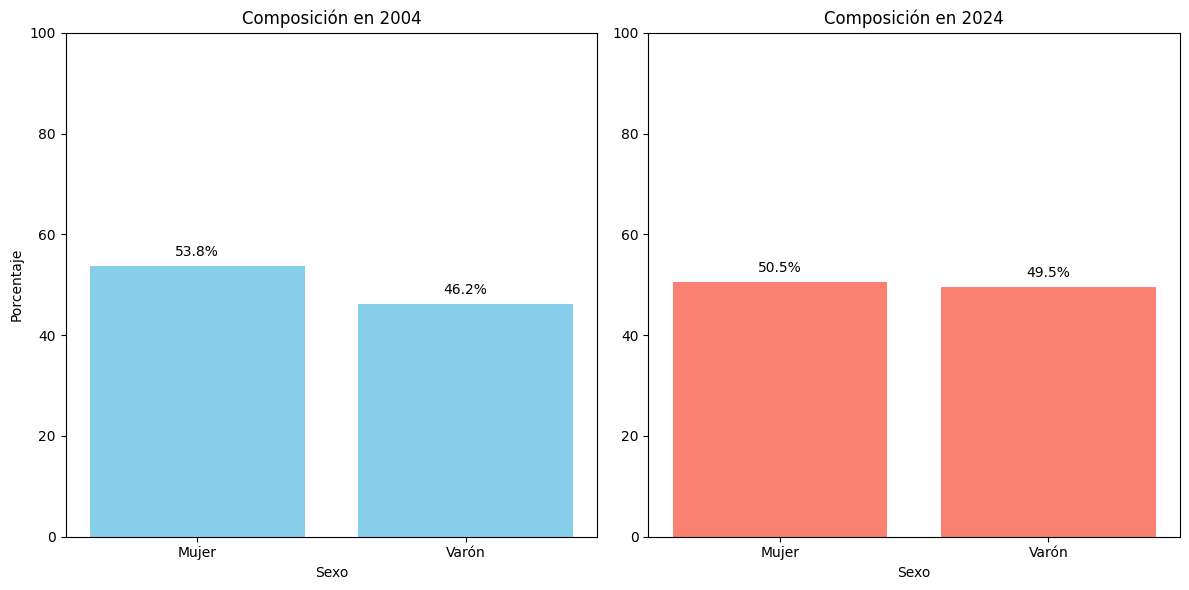

In [15]:
composicion_bar(data_2004_counts, data_2024_counts, 'Sexo')

### Matriz de correlación

In [16]:
columnas = ['año', 'ch04', 'ch06', 'ch07', 'ch08', 'nivel_ed', 'estado', 'cat_inac', 'ipcf']

In [17]:
# Sacamos esta función del link en la consigna
def heatmap(x, y, size):
    fig, ax = plt.subplots(figsize = (10,8))
    
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), 
        y=y.map(y_to_num), 
        s=size * size_scale,
        marker='s'
    )
    
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)

In [18]:
# Como la mayoría de las variables son catgóricas, para hacer las correlaciones tengo que conseguir las dummies
data_dummies = pd.get_dummies(data[columnas], prefix= '', prefix_sep= '')

In [19]:
# Vamos a eliminar las columnas que tienen todo False
data_dummies = data_dummies.loc[:, (data_dummies != 0).any(axis=0)]

In [20]:
data_dummies = data_dummies.rename(columns = {'ipcf': 'Ingreso per cápita Familiar', 'ch06': 'Edad', 'Otros': 'Categoría de Inactividad: Otros'})

In [21]:
def heatmap_from_melted_data(data, x_col, y_col, value_col, cmap=None, size_scale=500, rotation=45):
    """
    Crea un heatmap a partir de datos en formato 'melted' sin etiquetas en las celdas.

    Parámetros:
    - data: DataFrame con los datos en formato 'melted'.
    - x_col: Nombre de la columna para las etiquetas del eje x.
    - y_col: Nombre de la columna para las etiquetas del eje y.
    - value_col: Nombre de la columna con los valores de correlación.
    - cmap: Paleta de colores para el heatmap (opcional).
    - size_scale: Escala para el tamaño de los marcadores (solo para scatter opcional).
    - rotation: Rotación de las etiquetas del eje x.

    Devuelve:
    - ax: Eje de Matplotlib con el heatmap.
    """
    # Crear una matriz para sns.heatmap
    pivoted_data = data.pivot(index=y_col, columns=x_col, values=value_col)
    
    if cmap is None:
        cmap = sns.diverging_palette(20, 220, n=200)
    
    # Dibujar el heatmap sin anotaciones en las celdas
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        pivoted_data,
        cmap=cmap,
        center=0,
        annot=False,  # Desactivar anotaciones en las celdas
        square=True,
        ax=ax
    )
    
    # Configuración de etiquetas
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, horizontalalignment='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
   
    # Eliminar nombres de los ejes
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    plt.show()
    return ax

In [22]:
# Calcular correlaciones
corr = data_dummies.loc[data_dummies['año'] == 2004].corr().reset_index().melt(id_vars='index')
corr.columns = ['x', 'y', 'value']  # Modificar nombres de columnas

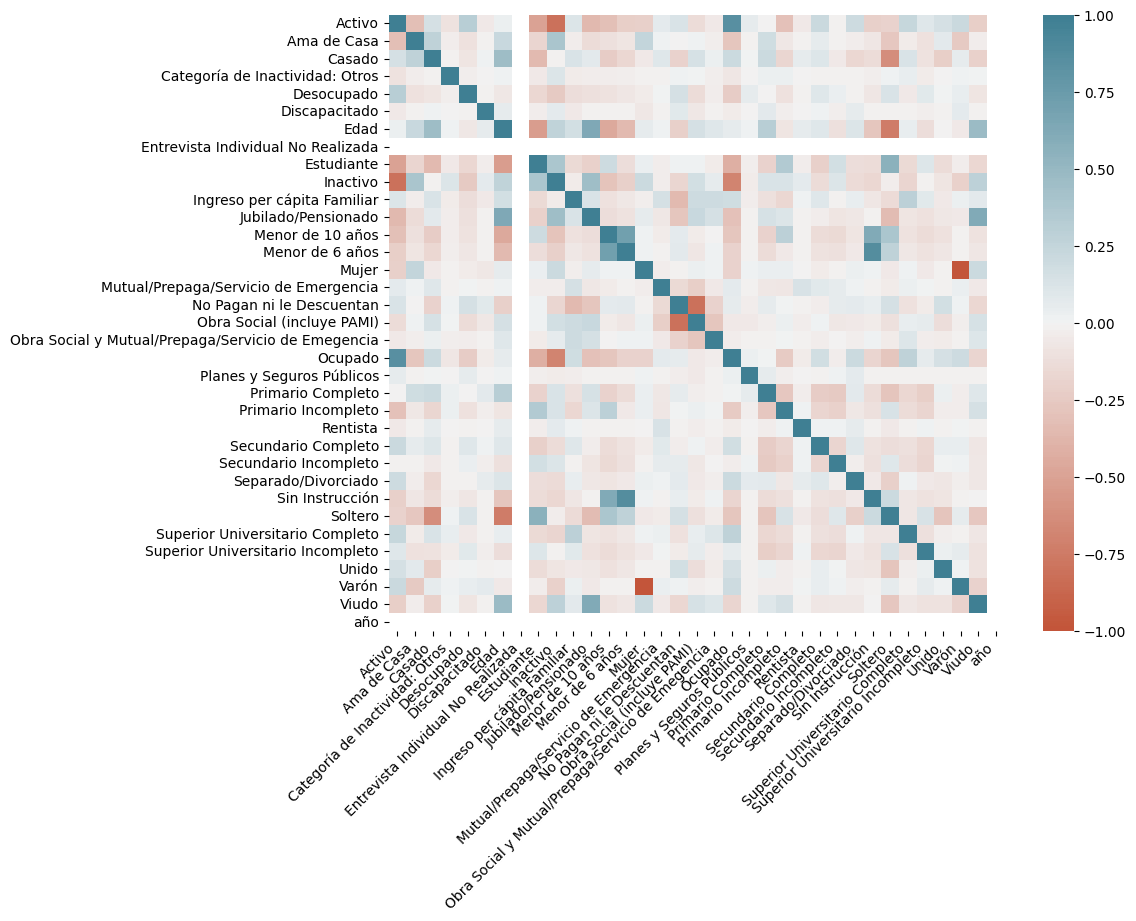

<Axes: >

In [23]:
# Crear heatmap sin etiquetas en las celdas
heatmap_from_melted_data(
    data=corr,
    x_col='x',
    y_col='y',
    value_col='value'
)

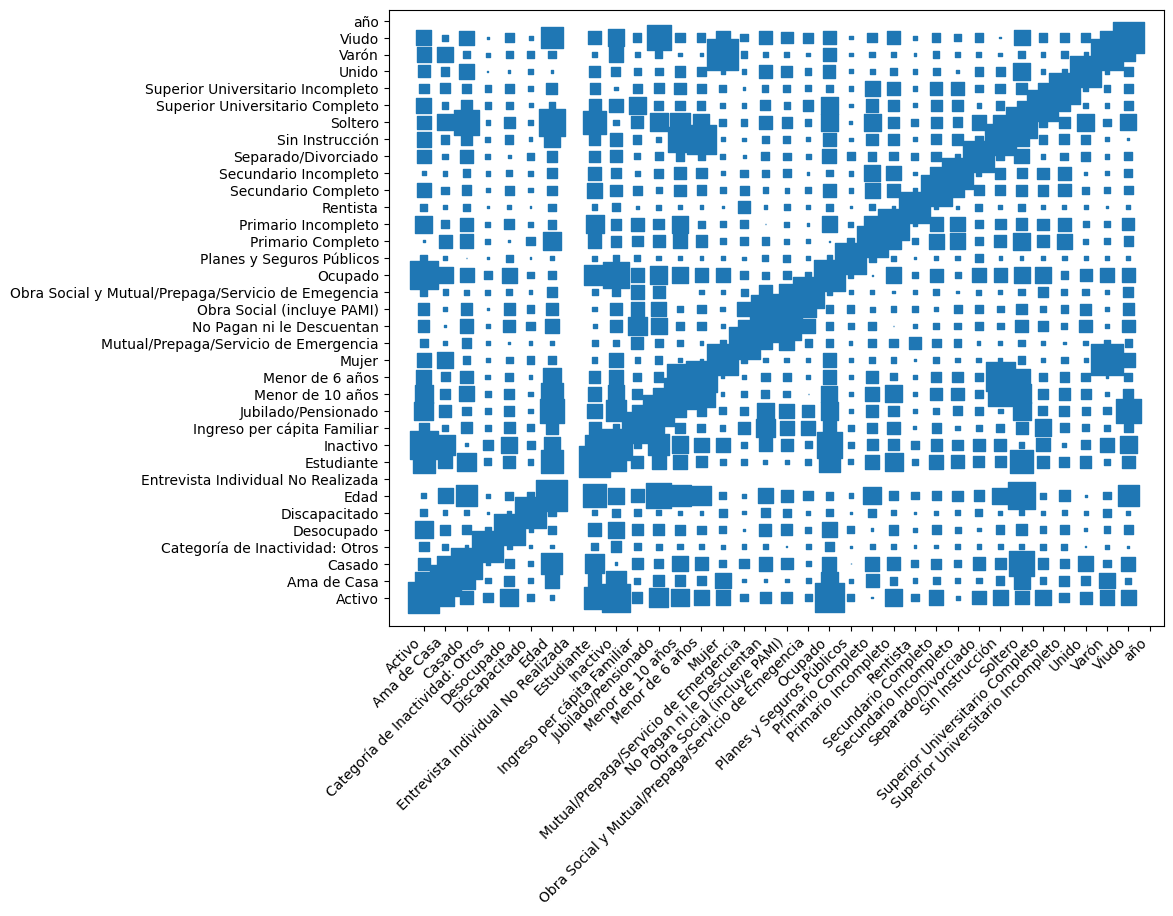

In [24]:
corr = data_dummies.loc[data_dummies['año'] == 2004].corr() # Saco la correlación
corr = pd.melt(corr.reset_index(), id_vars='index') # Lo transforma en un df de tres columnas
corr.columns = ['x', 'y', 'value'] # Le cambio el nombre a las columnas

heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)

In [25]:
# Calcular correlaciones
corr = data_dummies.loc[data_dummies['año'] == 2024].corr().reset_index().melt(id_vars='index')
corr.columns = ['x', 'y', 'value']  # Modificar nombres de columnas

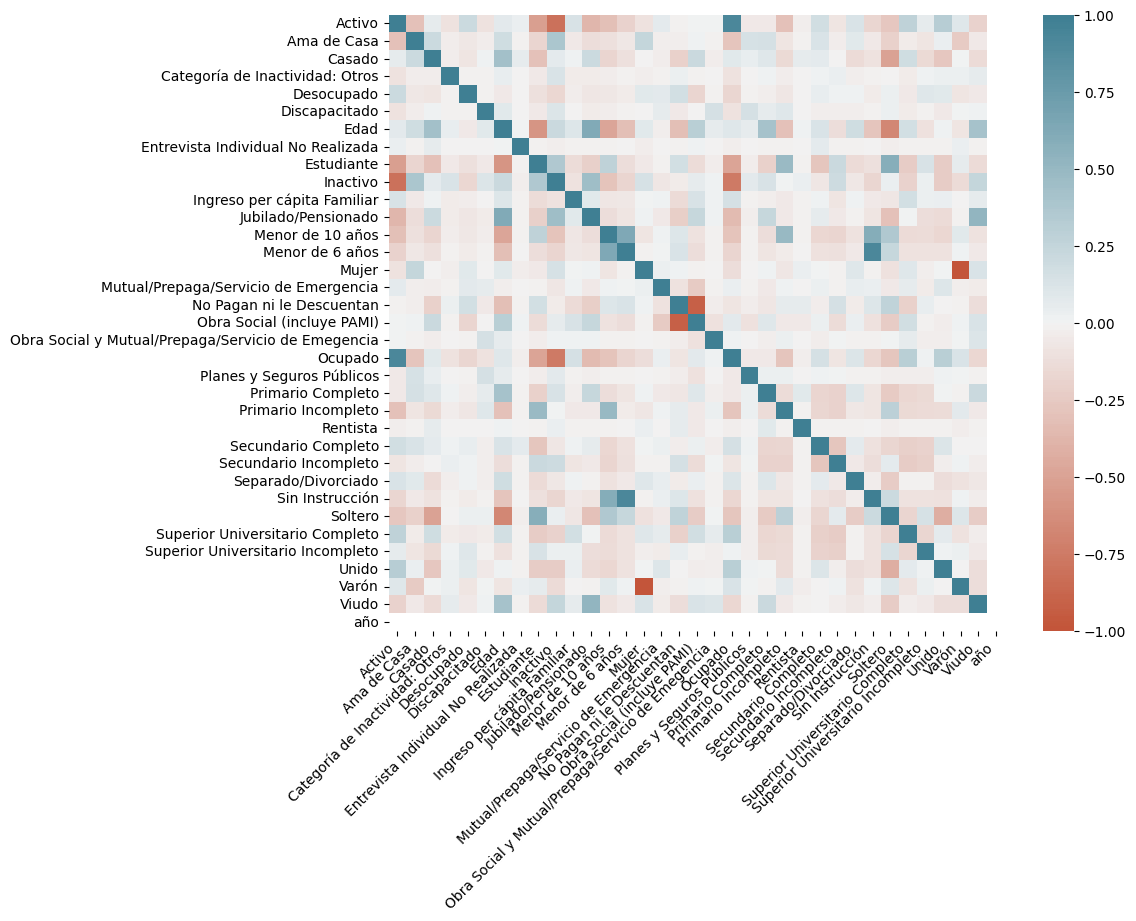

<Axes: >

In [26]:
# Crear heatmap sin etiquetas en las celdas
heatmap_from_melted_data(
    data=corr,
    x_col='x',
    y_col='y',
    value_col='value'
)

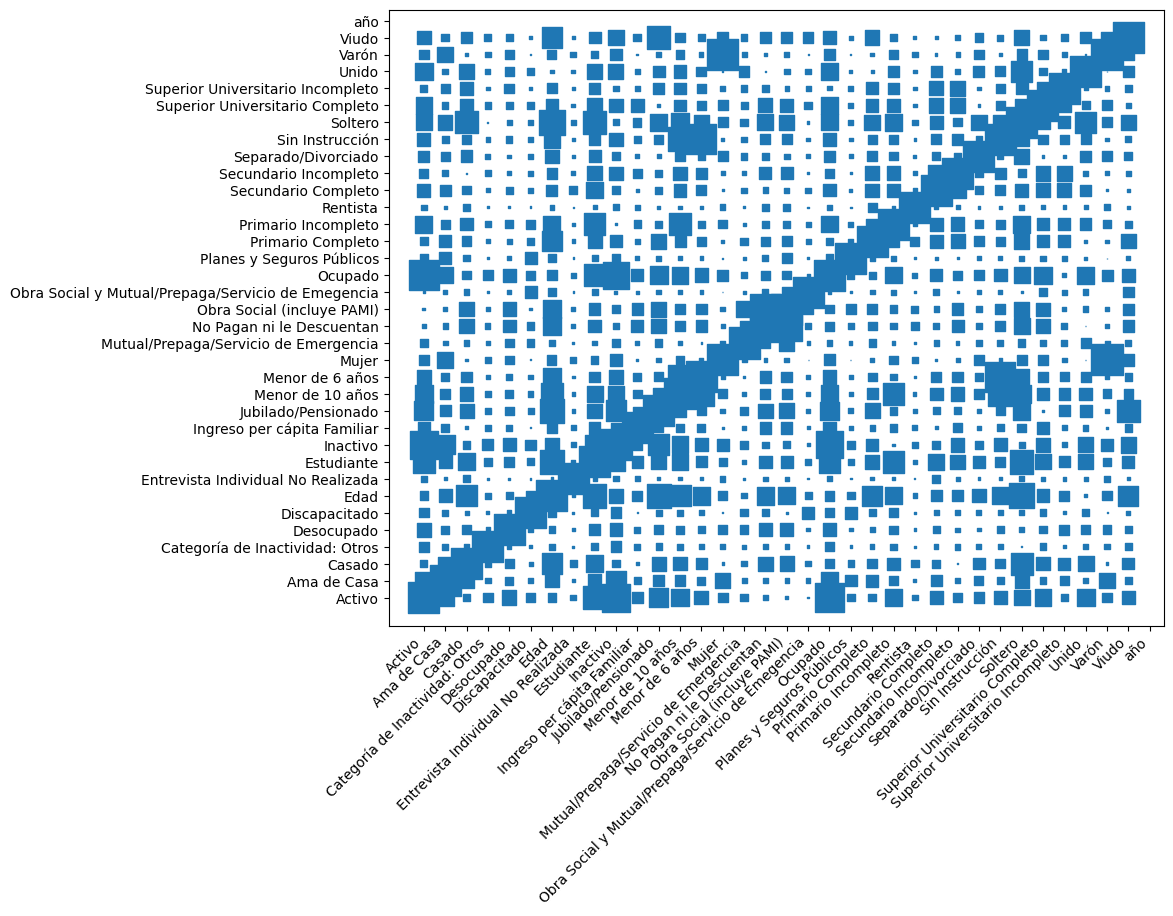

In [27]:
corr = data_dummies.loc[data_dummies['año'] == 2024].corr()
corr = pd.melt(corr.reset_index(), id_vars='index')
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)

### Desocupados, Inactivos y Ocupados

In [28]:
agregacion_2004 = data.loc[data['año'] == 2004].groupby('estado', observed= True).agg(count=('ipcf', 'size'),mean_ipcf=('ipcf', 'mean'))
print(agregacion_2004)

                  count   mean_ipcf
estado                             
Ocupado             440  399.765731
Desocupado           91  206.938540
Inactivo            496  318.462250
Menor de 10 años    117  246.184432


In [29]:
agregacion_2024 = data.loc[data['año'] == 2024].groupby('estado', observed = True).agg(count=('ipcf', 'size'),mean_ipcf=('ipcf', 'mean'))
print(agregacion_2024)

                                    count      mean_ipcf
estado                                                  
Entrevista Individual No Realizada      1       0.000000
Ocupado                               432  169874.557847
Desocupado                             38  105006.578947
Inactivo                              425  117397.605247
Menor de 10 años                      102   96909.033627


In [30]:
respondieron = data.loc[data['estado'] != 'Entrevista Individual No Realizada']
norespondieron = data.loc[data['estado'] == 'Entrevista Individual No Realizada']

### Composición PEA

In [34]:
respondieron.loc[:, 'pea'] = np.where(respondieron['estado'].isin(['Ocupado', 'Desocupado']), 1, 0)
respondieron.loc[:, 'pea'] = respondieron['pea'].astype('category')

In [35]:
respondieron_2004_counts = respondieron.loc[respondieron['año']==2004]['pea'].value_counts(normalize=True) * 100
respondieron_2024_counts = respondieron.loc[respondieron['año']==2024]['pea'].value_counts(normalize=True) * 100

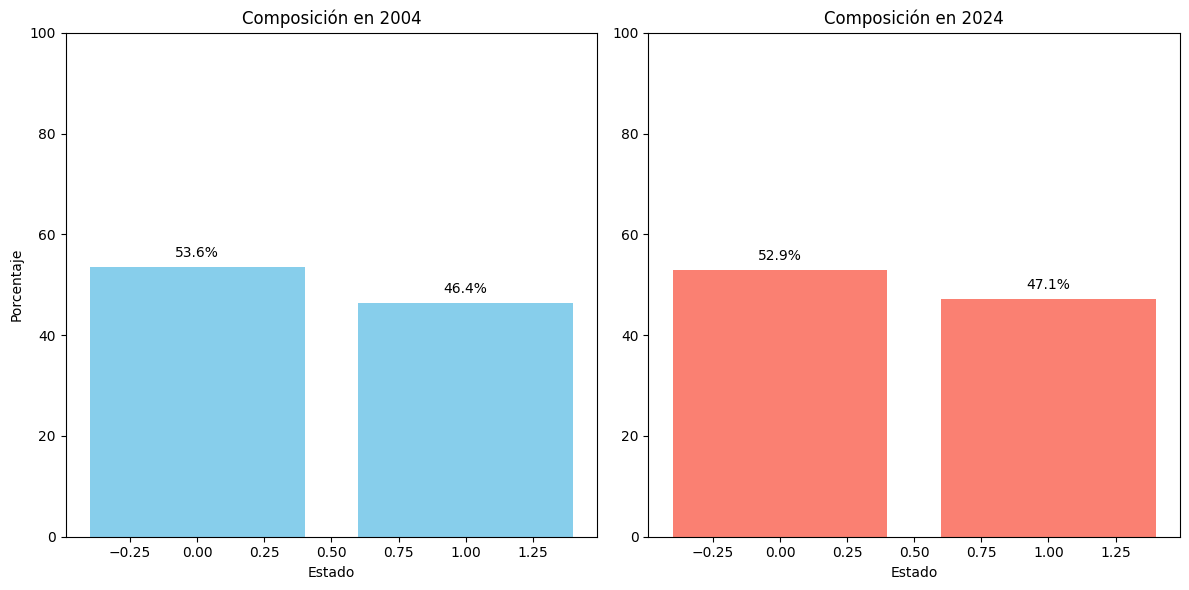

In [36]:
composicion_bar(respondieron_2004_counts, respondieron_2024_counts, 'Estado')

### Composición PET

In [37]:
respondieron.loc[:, 'pet'] = np.where((respondieron['ch06'] > 15) & (respondieron['ch06'] < 65), 1, 0)
respondieron.loc[:, 'pet'] = respondieron['pet'].astype('category')

C:\Users\HP\AppData\Local\Temp\ipykernel_85960\712394797.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  respondieron.loc[:, 'pet'] = np.where((respondieron['ch06'] > 15) & (respondieron['ch06'] < 65), 1, 0)
C:\Users\HP\AppData\Local\Temp\ipykernel_85960\712394797.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron.loc[:, 'pet'] = np.where((respondieron['ch06'] > 15) & (respondieron['ch06'] < 65), 1, 0)


In [38]:
respondieron_2004_counts = respondieron.loc[respondieron['año']==2004]['pet'].value_counts(normalize=True) * 100
respondieron_2024_counts = respondieron.loc[respondieron['año']==2024]['pet'].value_counts(normalize=True) * 100

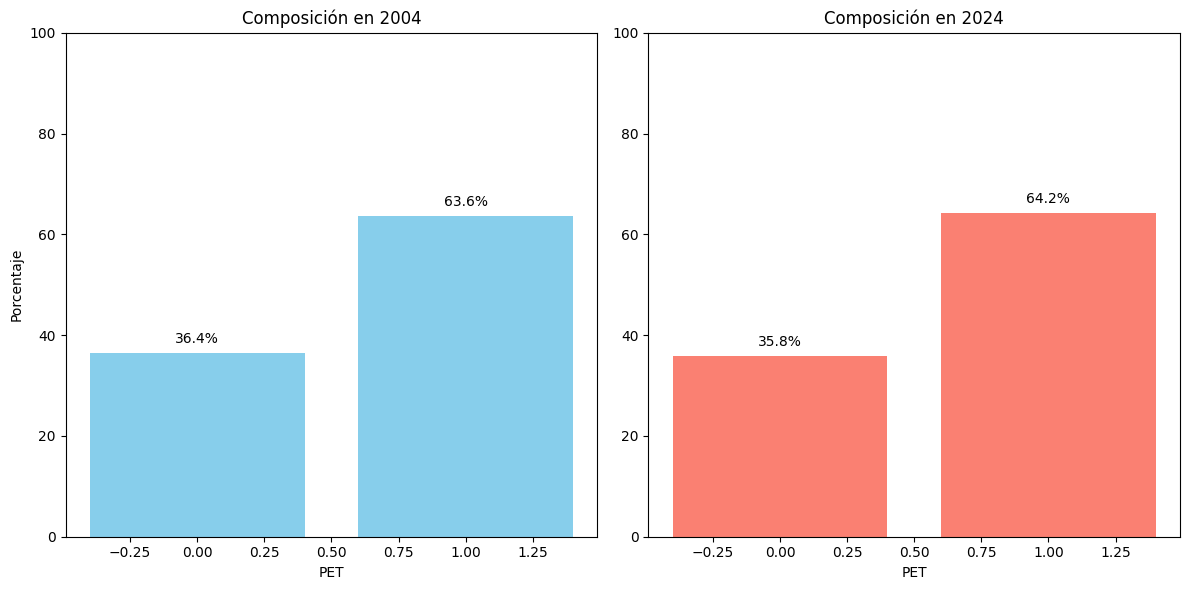

In [39]:
composicion_bar(respondieron_2004_counts, respondieron_2024_counts, 'PET')

### Desocupados

In [ ]:
respondieron.loc[:, 'desocupada'] = np.where(respondieron['estado'].isin(['Desocupado']), 1, 0)
respondieron.loc[:, 'desocupada'] = respondieron['desocupada'].astype('category')

In [ ]:
total_2004 = respondieron.loc[respondieron['año']==2004].groupby(['nivel_ed'], observed = True)['nivel_ed'].count()
desocupados_2004 = respondieron.loc[respondieron['año'] == 2004].groupby(['nivel_ed', 'desocupada'], observed = True)['desocupada'].count()
proporcion_desocupados_2004 = desocupados_2004 / total_2004

proporcion_desocupados_2004 = proporcion_desocupados_2004[proporcion_desocupados_2004.index.get_level_values('desocupada') == 1]
proporcion_desocupados_2004 = proporcion_desocupados_2004.droplevel('desocupada')

proporcion_desocupados_2004 = proporcion_desocupados_2004.reset_index() 
proporcion_desocupados_2004.columns = ['Nivel Educativo', 'Proporción'] 

print(proporcion_desocupados_2004)

                     Nivel Educativo  Proporción
0                Primario Incompleto    0.019704
1                  Primario Completo    0.076364
2              Secundario Incompleto    0.102564
3                Secundario Completo    0.137500
4  Superior Universitario Incompleto    0.133758
5    Superior Universitario Completo    0.034483


In [ ]:
total_2024 = respondieron.loc[respondieron['año']==2024].groupby('nivel_ed', observed = True)['nivel_ed'].count()
desocupados_2024 = respondieron.loc[respondieron['año'] == 2024].groupby(['nivel_ed', 'desocupada'], observed = True)['desocupada'].count()
proporcion_desocupados_2024 = desocupados_2024 / total_2024

proporcion_desocupados_2024 = proporcion_desocupados_2024[proporcion_desocupados_2024.index.get_level_values('desocupada') == 1]
proporcion_desocupados_2024 = proporcion_desocupados_2024.droplevel('desocupada')

proporcion_desocupados_2024 = proporcion_desocupados_2024.reset_index() 
proporcion_desocupados_2024.columns = ['Nivel Educativo', 'Proporción'] 

print(proporcion_desocupados_2024)

                     Nivel Educativo  Proporción
0                  Primario Completo    0.024793
1              Secundario Incompleto    0.044843
2                Secundario Completo    0.055838
3  Superior Universitario Incompleto    0.085106
4    Superior Universitario Completo    0.012987


In [ ]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100] 
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']

respondieron.loc[:, 'edad_categoria'] = pd.cut(respondieron['ch06'], bins=bins, labels=labels, right=False)

C:\Users\HP\AppData\Local\Temp\ipykernel_85960\2075242179.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  respondieron['edad_categoria'] = pd.cut(respondieron['ch06'], bins=bins, labels=labels, right=False)
C:\Users\HP\AppData\Local\Temp\ipykernel_85960\2075242179.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  respondieron['edad_categoria'] = pd.cut(respondieron['ch06'], bins=bins, labels=labels, right=False)


In [47]:
total_2004 = respondieron.loc[respondieron['año']==2004].groupby('edad_categoria', observed = True)['edad_categoria'].count()
desocupados_2004 = respondieron.loc[respondieron['año'] == 2004].groupby(['edad_categoria', 'desocupada'], observed=True)['desocupada'].count()
proporcion_desocupados_2004 = desocupados_2004 / total_2004

proporcion_desocupados_2004 = proporcion_desocupados_2004[proporcion_desocupados_2004.index.get_level_values('desocupada') == 1]
proporcion_desocupados_2004 = proporcion_desocupados_2004.droplevel('desocupada')

proporcion_desocupados_2004 = proporcion_desocupados_2004.reset_index() 
proporcion_desocupados_2004.columns = ['Categoría de Edad', 'Proporción'] 

print(proporcion_desocupados_2004)

  Categoría de Edad  Proporción
0             10-19    0.068421
1             20-29    0.184685
2             30-39    0.097345
3             40-49    0.084507
4             50-59    0.041322
5             60-69    0.082474
6             70-79    0.011765


In [48]:
total_2024 = respondieron.loc[respondieron['año']==2024].groupby('edad_categoria', observed = True)['edad_categoria'].count()
desocupados_2024 = respondieron.loc[respondieron['año'] == 2024].groupby(['edad_categoria', 'desocupada'], observed=True)['desocupada'].count()
proporcion_desocupados_2024 = desocupados_2024 / total_2024

proporcion_desocupados_2024 = proporcion_desocupados_2024[proporcion_desocupados_2024.index.get_level_values('desocupada') == 1]
proporcion_desocupados_2024 = proporcion_desocupados_2024.droplevel('desocupada')

proporcion_desocupados_2024 = proporcion_desocupados_2024.reset_index() 
proporcion_desocupados_2024.columns = ['Categoría de Edad', 'Proporción'] 

print(proporcion_desocupados_2024)

  Categoría de Edad  Proporción
0             10-19    0.020270
1             20-29    0.089888
2             30-39    0.068702
3             40-49    0.055118
4             50-59    0.019417
5             60-69    0.012048


# Clasificación

In [278]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score

In [279]:
columnas = ['ch04', 'ch06', 'ch07', 'ch08', 'nivel_ed', 'cat_inac', 'ipcf']

In [280]:
y_2004 = respondieron.loc[respondieron['año']==2004]['desocupada']
y_2024 = respondieron.loc[respondieron['año']==2024]['desocupada']

x_2004 = pd.get_dummies(respondieron.loc[respondieron['año']==2004][columnas])
x_2024 = pd.get_dummies(respondieron.loc[respondieron['año']==2024][columnas])

In [281]:
x_2004['constante'] = 1
x_2024.loc[:,'constante'] = 1

In [282]:
x_train_2004, x_test_2004, y_train_2004, y_test_2004 = train_test_split(x_2004, y_2004, test_size = 0.3, random_state = 101)
x_train_2024, x_test_2024, y_train_2024, y_test_2024 = train_test_split(x_2024, y_2024, test_size = 0.3, random_state = 101)

In [283]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    cm = confusion_matrix(y_test, y_pred)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    return cm, fpr, tpr, auc, accuracy

In [284]:
models = {
    'Regresión Logística': LogisticRegression(max_iter= 10000),
    'Análisis Discriminante Lineal': LinearDiscriminantAnalysis(),
    'KNN (k=3)': KNeighborsClassifier(n_neighbors=3),
    'Naive Bayes': GaussianNB()
}

## 2004

In [285]:
results = {}
print("Resultados para 2004:")
for model_name, model in models.items():
    cm, fpr, tpr, auc, accuracy = evaluate_model(model, x_train_2004, x_test_2004, y_train_2004, y_test_2004)
    results[model_name] = {
        'Matriz de Confusión': cm,
        'AUC': auc,
        'Accuracy': accuracy,
        'FPR': fpr,
        'TPR': tpr
    }

    print(f"{model_name}:")
    print(f"Matriz de Confusión:\n{cm}")
    print(f"AUC: {auc:.2f}")
    print(f"Accuracy: {accuracy:.2f}\n")


Resultados para 2004:
Regresión Logística:
Matriz de Confusión:
[[310   2]
 [ 25   7]]
AUC: 0.91
Accuracy: 0.92

Análisis Discriminante Lineal:
Matriz de Confusión:
[[294  18]
 [ 13  19]]
AUC: 0.91
Accuracy: 0.91

KNN (k=3):
Matriz de Confusión:
[[303   9]
 [ 26   6]]
AUC: 0.65
Accuracy: 0.90

Naive Bayes:
Matriz de Confusión:
[[183 129]
 [  0  32]]
AUC: 0.89
Accuracy: 0.62



### Curva ROC

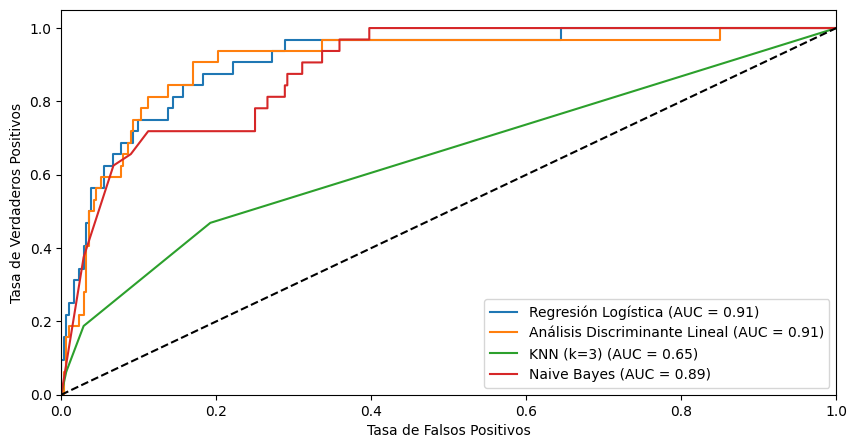

In [286]:
plt.figure(figsize=(10, 5))
for model_name, metrics in results.items():
    plt.plot(metrics['FPR'], metrics['TPR'], label=f'{model_name} (AUC = {metrics["AUC"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.show()

### 2024

In [287]:
results.clear() # Limpiamos el diccionario con los resultados del 2004
print("Resultados para 2024:")
for model_name, model in models.items():
    cm, fpr, tpr, auc, accuracy = evaluate_model(model, x_train_2024, x_test_2024, y_train_2024, y_test_2024)
    results[model_name] = {
        'Matriz de Confusión': cm,
        'AUC': auc,
        'Accuracy': accuracy,
        'FPR': fpr,
        'TPR': tpr
    }

    print(f"{model_name}:")
    print(f"Matriz de Confusión:\n{cm}")
    print(f"AUC: {auc:.2f}")
    print(f"Accuracy: {accuracy:.2f}\n")

Resultados para 2024:
Regresión Logística:
Matriz de Confusión:
[[290   0]
 [ 10   0]]
AUC: 0.87
Accuracy: 0.97

Análisis Discriminante Lineal:
Matriz de Confusión:
[[288   2]
 [  8   2]]
AUC: 0.85
Accuracy: 0.97

KNN (k=3):
Matriz de Confusión:
[[286   4]
 [ 10   0]]
AUC: 0.55
Accuracy: 0.95

Naive Bayes:
Matriz de Confusión:
[[290   0]
 [ 10   0]]
AUC: 0.69
Accuracy: 0.97



### Curva ROC

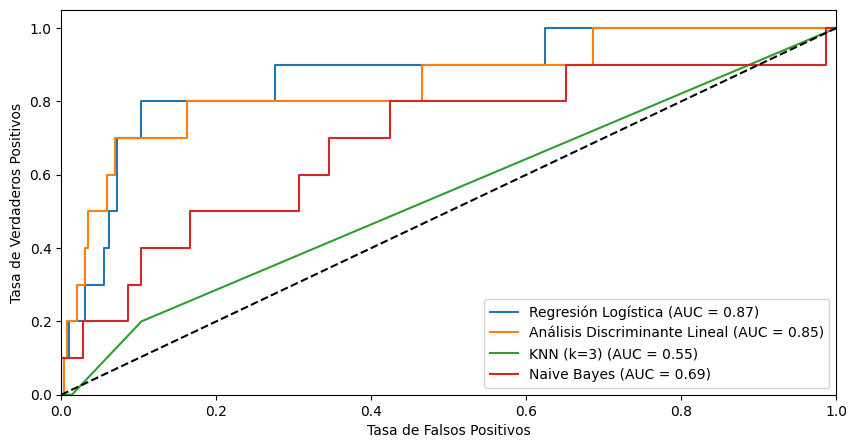

In [288]:
plt.figure(figsize=(10, 5))
for model_name, metrics in results.items():
    plt.plot(metrics['FPR'], metrics['TPR'], label=f'{model_name} (AUC = {metrics["AUC"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.show()

## Conclusiones

Para este problema, el modelo logístico y el naive bayes parecen ser los que mejor predicen fuera de la muestra, ya que muestran el mejor accuracy y AUC. Son tan buenos que en 2004 ni siquiera tienen falsos positivos ni negativos. En 2024 les cuesta un poco más, pero en términos generales predicen muy bien

## Predecir en No Respondieron

Tenemos una única observación para norespondieron

In [289]:
norespondieron_dummies = pd.get_dummies(norespondieron[columnas])
norespondieron_dummies.loc[:, 'constante'] = 1

Elegimos el modelo logístico de 2024 para predecir el valor de esta observación, ya que es el que menos falsos positivos o negativos tiene dentro de los modelos de 2024

In [290]:
lr = LogisticRegression(max_iter= 10000)
lr.fit(x_train_2024, y_train_2024)
    
y_pred = lr.predict(norespondieron_dummies)
print(y_pred)

[0]


Predice que no va a estar desocupada esta persona